In [2]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import statsmodels.stats.multitest as multi
from scipy.stats import pearsonr
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
from matplotlib.ticker import MaxNLocator
import random
from Bio import SeqIO

In [3]:
kmer_info_df = pd.read_csv('/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/SHAP/circRNA_shap_output/kmer_importance_quantification_info.txt',sep = '\t', index_col=0)
kmer_info_df 

,mean_abs_shap,pearsonr_r,pearsonr_p,fdr
AAA,0.000425,0.054733,6.984029e-02,9.932637e-01
AAC,0.000501,-0.137856,4.545904e-06,9.632696e-04
AAG,0.000243,0.405544,1.019388e-44,6.880871e-42
AAT,0.000452,-0.187473,3.834571e-10,1.085184e-07
ACA,0.000280,0.168822,1.821142e-08,4.771380e-06
...,...,...,...,...
TTTGT,0.001073,0.712826,4.644321e-171,5.879710e-168
TTTTA,0.001229,0.737510,4.657460e-189,6.012781e-186
TTTTC,0.000090,0.539147,8.147296e-84,7.609574e-81
TTTTG,0.000408,0.331777,1.268480e-29,6.748312e-27


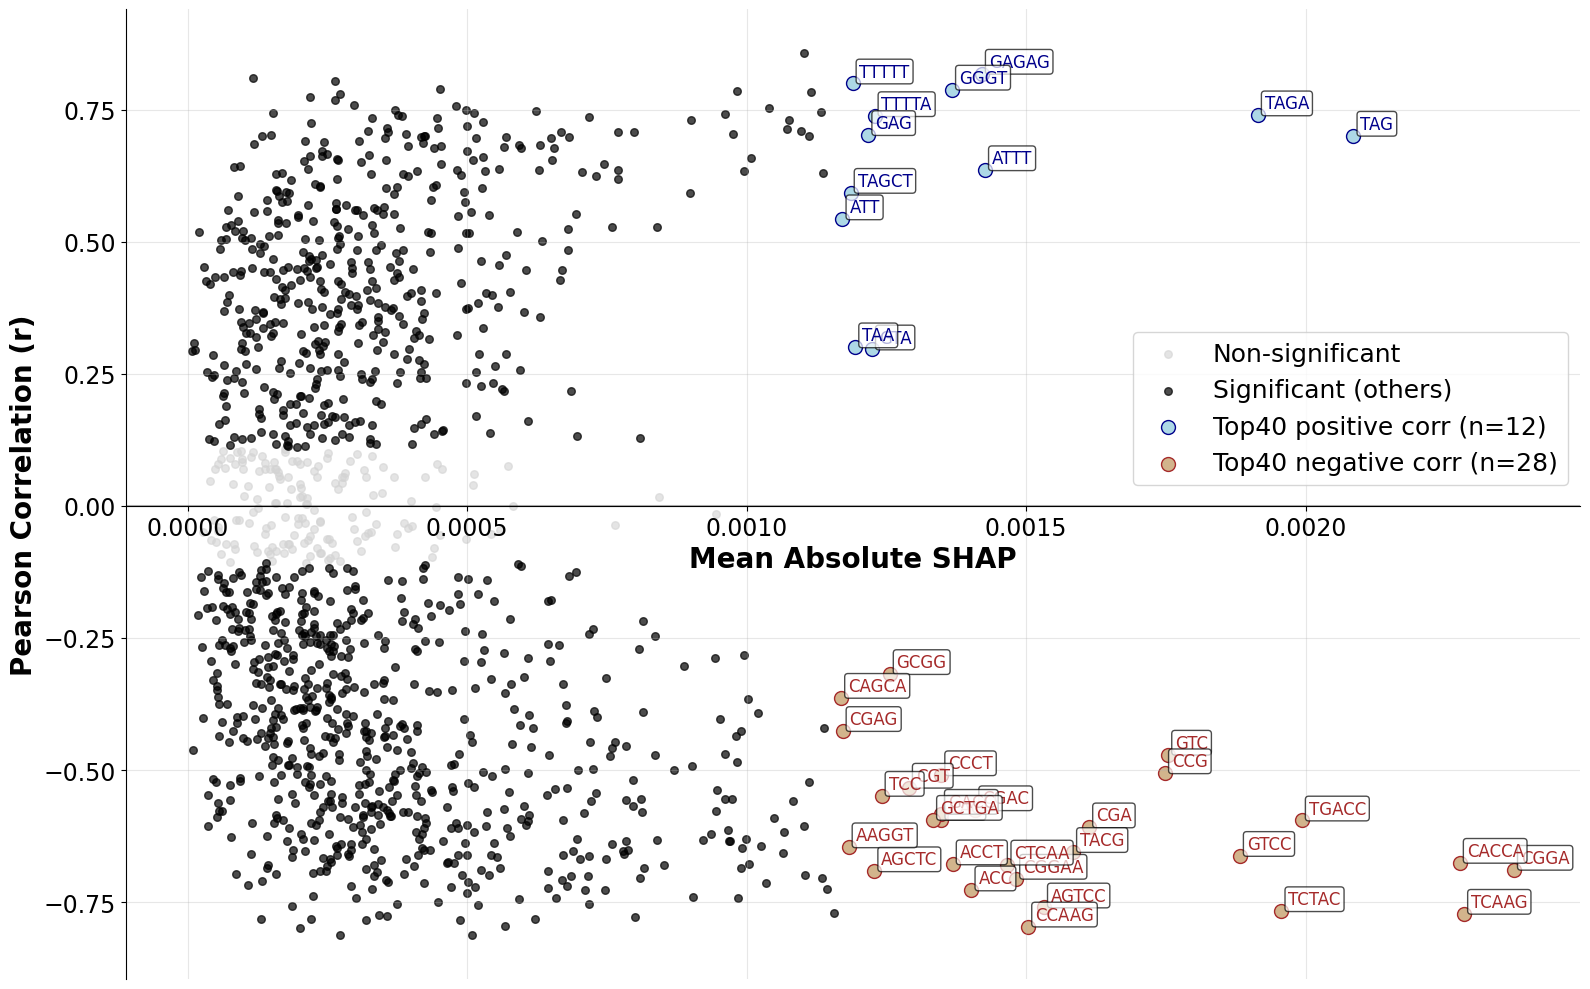

总显著kmer数量: 1186
Top 40中正相关kmer数量: 12
Top 40中负相关kmer数量: 28

Top 5 positive correlation kmers:
       mean_abs_shap  pearsonr_r     pearsonr_p            fdr
TAG         0.002085    0.700383  1.081759e-162  1.345708e-159
TAGA        0.001914    0.738978  3.415331e-190  4.419439e-187
ATTT        0.001426    0.635135  4.509642e-125  5.064328e-122
GAGAG       0.001421    0.817720  3.754320e-265  5.042052e-262
GGGT        0.001367    0.787665  8.829173e-233  1.176929e-229

Top 5 negative correlation kmers:
       mean_abs_shap  pearsonr_r     pearsonr_p            fdr
CGGA        0.002372   -0.688656  3.401126e-155  4.139170e-152
TCAAG       0.002283   -0.771982  6.562920e-218  8.663054e-215
CACCA       0.002275   -0.675490  3.424465e-147  4.078538e-144
TGACC       0.001993   -0.595432  2.601461e-106  2.726331e-103
TCTAC       0.001956   -0.767017  1.896913e-213  2.498235e-210


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 筛选显著的kmer (pearsonr_p < 0.05 and fdr < 0.05)
significant_kmers = kmer_info_df[(kmer_info_df['pearsonr_p'] < 0.05) & 
                                (kmer_info_df['fdr'] < 0.05)].copy()

# 按mean_abs_shap排序，选取前40个
top40_kmers = significant_kmers.nlargest(40, 'mean_abs_shap')

# 分类kmer
positive_corr = top40_kmers[top40_kmers['pearsonr_r'] > 0]
negative_corr = top40_kmers[top40_kmers['pearsonr_r'] < 0]
all_other_significant = significant_kmers[~significant_kmers.index.isin(top40_kmers.index)]
non_significant = kmer_info_df[~((kmer_info_df['pearsonr_p'] < 0.05) & 
                                (kmer_info_df['fdr'] < 0.05))]

# 创建散点图（顺时针旋转90度：x轴变为mean_abs_shap，y轴变为pearsonr_r）
fig, ax = plt.subplots(figsize=(16, 10))

# 绘制非显著的点 (灰色)
ax.scatter(non_significant['mean_abs_shap'],
           non_significant['pearsonr_r'], 
           c='lightgray', alpha=0.6, s=30, label='Non-significant')

# 绘制其他显著但不在top40的点 (黑色)
ax.scatter(all_other_significant['mean_abs_shap'],
           all_other_significant['pearsonr_r'], 
           c='black', alpha=0.7, s=30, label='Significant (others)')

# 绘制top40中正相关的kmer (浅蓝色)
ax.scatter(positive_corr['mean_abs_shap'],
           positive_corr['pearsonr_r'], 
           c='lightblue', s=100, edgecolors='darkblue', linewidth=1,
           label=f'Top40 positive corr (n={len(positive_corr)})')

# 绘制top40中负相关的kmer (浅棕色)
ax.scatter(negative_corr['mean_abs_shap'],
           negative_corr['pearsonr_r'], 
           c='tan', s=100, edgecolors='brown', linewidth=1,
           label=f'Top40 negative corr (n={len(negative_corr)})')

# 在蓝色点上标注kmer名称
for idx, row in positive_corr.iterrows():
    ax.annotate(idx, 
                (row['mean_abs_shap'], row['pearsonr_r']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12, color='darkblue',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

# 在棕色点上标注kmer名称
for idx, row in negative_corr.iterrows():
    ax.annotate(idx, 
                (row['mean_abs_shap'], row['pearsonr_r']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12, color='brown',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

# 将x轴移动到y=0的位置
ax.spines['bottom'].set_position('zero')

# 隐藏顶部和右侧边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 添加参考线
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# 设置标签和标题
ax.set_xlabel('Mean Absolute SHAP', fontsize=20, fontweight='bold')
ax.set_ylabel('Pearson Correlation (r)', fontsize=20, fontweight='bold')
ax.tick_params(axis='x', labelsize=17)  # X轴刻度字体大小
ax.tick_params(axis='y', labelsize=17)  # Y轴刻度字体
# ax.set_title('K-mer SHAP Importance vs Correlation\n(Top 40 by mean absolute SHAP)', fontsize=14)
# ax.legend(loc='upper right', fontsize=16)
ax.legend(bbox_to_anchor=(1, 0.68), loc='upper right', fontsize=18)
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)

# 设置网格
ax.grid(True, alpha=0.3)

# 调整布局
plt.tight_layout()
plt.show()

# 打印统计信息
print(f"总显著kmer数量: {len(significant_kmers)}")
print(f"Top 40中正相关kmer数量: {len(positive_corr)}")
print(f"Top 40中负相关kmer数量: {len(negative_corr)}")
print(f"\nTop 5 positive correlation kmers:")
print(positive_corr.nlargest(5, 'mean_abs_shap')[['mean_abs_shap', 'pearsonr_r', 'pearsonr_p', 'fdr']])
print(f"\nTop 5 negative correlation kmers:")
print(negative_corr.nlargest(5, 'mean_abs_shap')[['mean_abs_shap', 'pearsonr_r', 'pearsonr_p', 'fdr']])

In [5]:
def ligate_sequence(seq, add_len):
    seq = str(seq)
    seqlen = len(seq)
    if seqlen >= add_len:
        extra = seq[:add_len]
    else:
        repeat_times = add_len // seqlen
        remainder = add_len % seqlen
        extra = seq * repeat_times + seq[:remainder]
    return seq + extra

# 加载circRNA序列
csv_path = "/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/reference_preprocessing/circRNA/output_with_sequences.csv"
df = pd.read_csv(csv_path, sep = '\t')
add_len = 4 
df["Sequence"] = df["Sequence"].apply(
    lambda x: ligate_sequence(x, add_len)
)
# 提取序列列
sequences = df["Sequence"].dropna()

# 打印统计信息
print(f"总显著kmer数量: {len(significant_kmers)}")


# 计算显著kmer的EV和cyto占比
num_bins = 100

# 获取显著的kmer列表
significant_kmer_list = significant_kmers.index.tolist()
ev_significant_kmers = significant_kmers[significant_kmers['pearsonr_r'] > 0].index.tolist()
cyto_significant_kmers = significant_kmers[significant_kmers['pearsonr_r'] < 0].index.tolist()
# print(f"显著正相关kmer数量: {len(ev_significant_kmers)/len(significant_kmers)*100:.2f}%")
# print(f"显著负相关kmer数量: {len(cyto_significant_kmers)/len(significant_kmers)*100:.2f}%")

# 计算每个显著kmer在100个bins上的频率占比分布
kmer_bin_counts = {kmer: np.zeros(num_bins) for kmer in significant_kmer_list}

for seq in sequences:
    seq_len = len(seq)
    extended_seq = seq + seq[:max(map(len, significant_kmer_list))]
    for kmer in significant_kmer_list:
        k = len(kmer)
        positions = [i for i in range(seq_len) if extended_seq[i:i+k] == kmer]
        for pos in positions:
            bin_idx = int((pos % seq_len) / seq_len * num_bins)
            kmer_bin_counts[kmer][bin_idx] += 1

for kmer in significant_kmer_list:
    kmer_bin_counts[kmer] /= len(sequences)


# 重新排列k-mer顺序：cyto颠倒 + ev颠倒
reordered_significant_kmers = cyto_significant_kmers[::-1] + ev_significant_kmers[::-1]

# 构建bin矩阵并计算频率占比
bin_matrix = np.array([kmer_bin_counts[kmer] for kmer in reordered_significant_kmers])
bin_sums = bin_matrix.sum(axis=0, keepdims=True)
bin_sums[bin_sums == 0] = 1
bin_matrix = bin_matrix / bin_sums

# # 计算每个kmer在100个位置上的平均频率占比
# cyto_indices = list(range(len(cyto_significant_kmers)))
# ev_indices = list(range(len(cyto_significant_kmers), len(cyto_significant_kmers) + len(ev_significant_kmers)))

# # 计算EV和cyto的平均频率占比
# if cyto_indices:
#     cyto_avg_freq = np.mean(bin_matrix[cyto_indices, :])
# else:
#     cyto_avg_freq = 0

# if ev_indices:
#     ev_avg_freq = np.mean(bin_matrix[ev_indices, :])
# else:
#     ev_avg_freq = 0
ev_kmer_indices = [reordered_significant_kmers.index(kmer) for kmer in ev_significant_kmers[::-1]]  # 获取EV k-mers在重排序列表中的索引
ev_total_proportion = bin_matrix[ev_kmer_indices].sum(axis=0)  # 按列求和，得到每个bin中EV k-mers的总占比


# 输出结果
print(f"\n=== 显著kmer的EV和cyto占比分析 ===")
print(f"显著kmer中EV kmer数量: {len(ev_significant_kmers)}")
print(f"显著kmer中cyto kmer数量: {len(cyto_significant_kmers)}")
print(f"EV kmer占显著kmer比例: {len(ev_significant_kmers)/len(significant_kmers)*100:.2f}%")
print(f"cyto kmer占显著kmer比例: {len(cyto_significant_kmers)/len(significant_kmers)*100:.2f}%")
print(f"平均占比: {ev_total_proportion.mean():.4f} ({ev_total_proportion.mean()*100:.2f}%)")
print(f"最小占比: {ev_total_proportion.min():.4f} ({ev_total_proportion.min()*100:.2f}%)")
print(f"最大占比: {ev_total_proportion.max():.4f} ({ev_total_proportion.max()*100:.2f}%)")
print(f"标准差: {ev_total_proportion.std():.4f}")

总显著kmer数量: 1186

=== 显著kmer的EV和cyto占比分析 ===
显著kmer中EV kmer数量: 493
显著kmer中cyto kmer数量: 693
EV kmer占显著kmer比例: 41.57%
cyto kmer占显著kmer比例: 58.43%
平均占比: 0.4570 (45.70%)
最小占比: 0.4405 (44.05%)
最大占比: 0.4783 (47.83%)
标准差: 0.0072


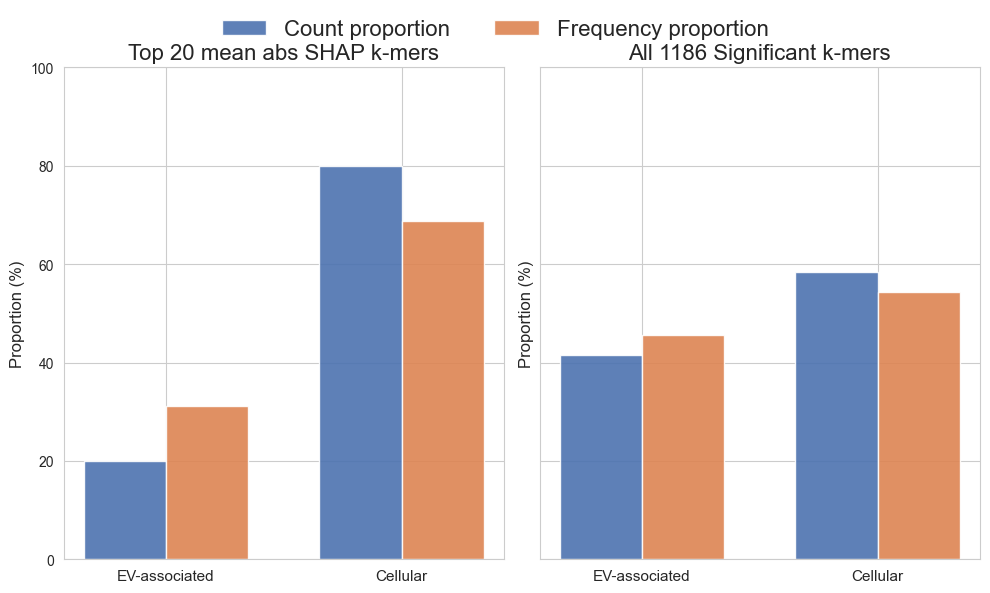

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
groups = ["Top 20 mean abs SHAP k-mers", "All 1186 Significant k-mers"]
categories = ["EV-associated", "Cellular"]
metrics = ["Count proportion", "Frequency proportion"]

# 数值
data = {
    "Top 20 mean abs SHAP k-mers": {
        "EV-associated": [20, 31.17],
        "Cellular": [80, 68.83],
    },
    "All 1186 Significant k-mers": {
        "EV-associated": [41.57, 45.70],
        "Cellular": [58.43, 54.30],
    },
}

# 绘图参数接口
bar_colors = ["#4C72B0", "#DD8452"]  # Count, Frequency
category_colors = {"EV-associated": "#6A9FB5", "Cellular": "#C44E52"}
title_fontsize = 16
label_fontsize = 12
tick_fontsize = 11
legend_fontsize = 16

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

for idx, group in enumerate(groups):
    ax = axes[idx]
    bar_width = 0.35
    x = np.arange(len(categories))

    for j, metric in enumerate(metrics):
        values = [data[group][cat][j] for cat in categories]
        ax.bar(
            x + j * bar_width - bar_width / 2,
            values,
            width=bar_width,
            label=metric if idx == 0 else "",
            color=bar_colors[j],
            alpha=0.9,
        )

    # 设置x轴
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=tick_fontsize)
    ax.set_title(group, fontsize=title_fontsize)
    ax.set_ylim(0, 100)
    ax.set_ylabel("Proportion (%)", fontsize=label_fontsize)

    # # 突出EV差距
    # ev_count, ev_freq = data[group]["EV-associated"]
    # ax.plot([0 - bar_width / 2, 0 + bar_width / 2],
    #         [ev_count, ev_freq], color="black", linestyle="--", linewidth=1)
    # ax.text(0, (ev_count + ev_freq) / 2, "freq > count",
    #         ha="center", va="bottom", fontsize=9, rotation=90)

# 添加图例
fig.legend(metrics, loc="upper center", ncol=2, fontsize=legend_fontsize, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [7]:
TOP40_SHAP_kmer = kmer_info_df.sort_values(by = 'mean_abs_shap', ascending=False).head(n = 40)

kmer_info_df['abs_pearsonr'] = kmer_info_df['pearsonr_r'].abs()
TOP40_pearsonr_kmer = kmer_info_df.sort_values(by = 'abs_pearsonr', ascending=False).head(n = 40)
common_index = TOP40_SHAP_kmer.index.intersection(TOP40_pearsonr_kmer.index)
common_index

Index(['TCAAG', 'TCTAC', 'AGTCC', 'CCAAG', 'GAGAG', 'GGGT', 'TTTTT'], dtype='object')

In [8]:
# 获取abs shap kmer最低的20个，作为随机突变目标
LESS20_SHAP_kmer = kmer_info_df.sort_values(by = 'mean_abs_shap', ascending=True).head(n = 20)
# LESS20_pearsonr_kmer = kmer_info_df.sort_values(by = 'abs_pearsonr', ascending=True).head(n = 20)
LESS20_SHAP_kmer.index

Index(['CGCGA', 'CGATA', 'GCGTA', 'ACGCC', 'CGTAG', 'GTTAC', 'GCACG', 'CCGAA',
       'GCGCA', 'CGACC', 'TGCGA', 'GCGCG', 'GTAAG', 'CGTTA', 'CCGGG', 'GTCGT',
       'TATCG', 'TAGCG', 'CATAA', 'TGCGG'],
      dtype='object')

In [9]:
TOP40_SHAP_kmer[(TOP40_SHAP_kmer['pearsonr_r'] < 0)].index


Index(['CGGA', 'TCAAG', 'CACCA', 'TGACC', 'TCTAC', 'GTCC', 'GTC', 'CCG', 'CGA',
       'TACG', 'AGTCC', 'CCAAG', 'CGGAA', 'CTCAA', 'CGAC', 'ACC', 'ACCT',
       'CAC', 'CCCT', 'GACC', 'GCTGA', 'CGT', 'GCGG', 'TCC', 'AGCTC', 'AAGGT',
       'CGAG', 'CAGCA'],
      dtype='object')

In [10]:
TOP40_SHAP_kmer[(TOP40_SHAP_kmer['pearsonr_r'] > 0)].index

Index(['TAG', 'TAGA', 'ATTT', 'GAGAG', 'GGGT', 'TTTTA', 'GTA', 'GAG', 'TAA',
       'TTTTT', 'TAGCT', 'ATT'],
      dtype='object')

In [11]:
# 将正类相关kmer突变
input_fasta = "/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/ML_models/circRNA_ML_Model_tridivided_Output/test_set_sequences.fasta"
output_fasta = "./test_EV_sequences_mutated.fasta"

high_shap_kmers = ['TAG', 'TAGA', 'ATTT', 'GAGAG', 'GGGT', 'TTTTA', 'GTA', 'GAG', 'TAA',
       'TTTTT', 'TAGCT', 'ATT']
low_shap_kmers = ['CGGA', 'TCAAG', 'CACCA', 'TGACC', 'TCTAC', 'GTCC', 'GTC', 'CCG', 'CGA',
       'TACG', 'AGTCC', 'CCAAG', 'CGGAA', 'CTCAA', 'CGAC', 'ACC', 'ACCT',
       'CAC', 'CCCT', 'GACC', 'GCTGA', 'CGT', 'GCGG', 'TCC', 'AGCTC', 'AAGGT',
       'CGAG', 'CAGCA'] 

random.seed(198)

# 工具函数：生成非重叠突变坐标
def find_non_overlapping_matches(seq, target_kmers):
    matches = []
    used = set()
    for kmer in target_kmers:
        start = 0
        while True:
            idx = seq.find(kmer, start)
            if idx == -1:
                break
            if all((i not in used) for i in range(idx, idx+len(kmer))):
                matches.append((idx, idx+len(kmer), kmer))
                used.update(range(idx, idx+len(kmer)))
            start = idx + 1
    matches.sort()
    return matches

# 主突变函数
def mutate_sequence(seq_str, high_kmers, low_kmers):
    matches = find_non_overlapping_matches(seq_str, high_kmers)
    seq_list = list(seq_str)
    for start, end, kmer in matches:
        replacement = random.choice(low_kmers)
        # 替换：长度不一致时直接替换start:end为新kmer
        seq_list[start:end] = list(replacement)
    return ''.join(seq_list)

# 读取并突变FASTA
mutated_records = []
for record in SeqIO.parse(input_fasta, "fasta"):
    seq = str(record.seq)
    
    # 只对序列名以_1结尾的序列进行突变
    if record.id.endswith('_1'):
        mutated_seq = mutate_sequence(seq, high_shap_kmers, low_shap_kmers)
        record.seq = mutated_seq
    
    mutated_records.append(record)

# 保存突变后的FASTA
with open(output_fasta, "w") as f:
    SeqIO.write(mutated_records, f, "fasta")

/lulabdata3/huangkeyun/miniconda/lib/python3.10/site-packages/Bio/SeqRecord.py:354: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


In [12]:
# 将负类相关kmer突变
input_fasta = "/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/ML_models/circRNA_ML_Model_tridivided_Output/test_set_sequences.fasta"
output_fasta = "./test_Cyto_sequences_mutated.fasta"

high_shap_kmers = ['CGCGA', 'CGATA', 'GCGTA', 'ACGCC', 'CGTAG', 'GTTAC', 'GCACG', 'CCGAA',
       'GCGCA', 'CGACC', 'TGCGA', 'GCGCG', 'GTAAG', 'CGTTA', 'CCGGG', 'GTCGT',
       'TATCG', 'TAGCG', 'CATAA', 'TGCGG']
low_shap_kmers = ['CGGA', 'TCAAG', 'CACCA', 'TGACC', 'TCTAC', 'GTCC', 'GTC', 'CCG', 'CGA',
       'TACG', 'AGTCC', 'CCAAG', 'CGGAA', 'CTCAA', 'CGAC', 'ACC', 'ACCT',
       'CAC', 'CCCT', 'GACC', 'GCTGA', 'CGT', 'GCGG', 'TCC', 'AGCTC', 'AAGGT',
       'CGAG', 'CAGCA']  

random.seed(198)

# 工具函数：生成非重叠突变坐标
def find_non_overlapping_matches(seq, target_kmers):
    matches = []
    used = set()
    for kmer in target_kmers:
        start = 0
        while True:
            idx = seq.find(kmer, start)
            if idx == -1:
                break
            if all((i not in used) for i in range(idx, idx+len(kmer))):
                matches.append((idx, idx+len(kmer), kmer))
                used.update(range(idx, idx+len(kmer)))
            start = idx + 1
    matches.sort()
    return matches

# 主突变函数
def mutate_sequence(seq_str, high_kmers, low_kmers):
    matches = find_non_overlapping_matches(seq_str, high_kmers)
    seq_list = list(seq_str)
    for start, end, kmer in matches:
        replacement = random.choice(low_kmers)
        # 替换：长度不一致时直接替换start:end为新kmer
        seq_list[start:end] = list(replacement)
    return ''.join(seq_list)

# 读取并突变FASTA
mutated_records = []
for record in SeqIO.parse(input_fasta, "fasta"):
    seq = str(record.seq)
    
    # 只对序列名以_0结尾的序列进行突变
    if record.id.endswith('_0'):
        mutated_seq = mutate_sequence(seq, high_shap_kmers, low_shap_kmers)
        record.seq = mutated_seq
    
    mutated_records.append(record)

# 保存突变后的FASTA
with open(output_fasta, "w") as f:
    SeqIO.write(mutated_records, f, "fasta")